In [1]:
import os, psutil

# Determine number of available (idle) cores
IDLE_THRESHOLD = 20.0  # percent
cpu_usages = psutil.cpu_percent(percpu=True, interval=1)
available_cores = sum(usage < IDLE_THRESHOLD for usage in cpu_usages)
available_cores = max(1, available_cores) - 4 # At least 1

available_cores = os.cpu_count()

import mplfinance
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Stable-Baselines3 imports
from stable_baselines3 import PPO,A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import SubprocVecEnv  # Use this instead of DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback

# Gymnasium (updated from Gym)
import gymnasium as gym
from gymnasium import Env,Wrapper
from gymnasium.spaces import Discrete, Box


In [2]:
# Load Data
df = pd.read_csv("MGOL.csv")  # Replace with actual file
df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%y %H:%M')
df.set_index('datetime', inplace=True)

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df.index = df.index + pd.Timedelta(hours=3)
df.index.name = 'Date'
df = df.drop(columns=['symbol', 'frame'])
df = df.iloc[:10]  # Select the first 30 rows
df_original = df
df = df[["close"]]

In [13]:
class ActionMasker(gym.Wrapper):
    def __init__(self, env: gym.Env, mask_fn: callable):
        super().__init__(env)
        self.mask_fn = mask_fn
        self.step_count = 0
        print(f"\n=== ActionMasker Initialization ===")
        print(f"- Original observation space: {env.observation_space}")
        print(f"- Action space: {env.action_space}")

    def step(self, action):
        print(f"\n=== ActionMasker.step() [Step {self.step_count}] ===")
        print(f"- Input action: {action}")
        
        # Get the step results from the environment
        obs, reward, done, truncated, info = self.env.step(action)
        
        print(f"- Raw observation shape: {np.asarray(obs).shape}")
        print(f"- Raw observation: {obs}")
        
        # Get and store the action mask
        action_mask = self.mask_fn(self.env)
        info['action_mask'] = action_mask
        
        print(f"- Action mask shape: {action_mask.shape}")
        print(f"- Action mask: {action_mask}")
        print(f"- Info keys: {list(info.keys())}")
        
        self.step_count += 1
        return obs, reward, done, truncated, info

    def reset(self, **kwargs):
        print("\n=== ActionMasker.reset() ===")
        obs, info = self.env.reset(**kwargs)
        
        print(f"- Initial observation shape: {np.asarray(obs).shape}")
        print(f"- Initial observation: {obs}")
        
        # Get and store the action mask
        action_mask = self.mask_fn(self.env)
        info['action_mask'] = action_mask
        
        print(f"- Action mask shape: {action_mask.shape}")
        print(f"- Action mask: {action_mask}")
        print(f"- Info keys: {list(info.keys())}")
        
        self.step_count = 0
        return obs, info

In [5]:
from stable_baselines3.common.policies import ActorCriticPolicy
import torch
import torch.nn.functional as F

class MaskedPPOPolicy(ActorCriticPolicy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, obs, action_mask=None, deterministic=False):
        # Ensure obs is float32
        obs = obs.to(dtype=torch.float32)
        
        # Get features
        features = self.extract_features(obs)
        
        # Get action distribution and values
        latent_pi, latent_vf = self.mlp_extractor(features)
        distribution = self._get_action_dist_from_latent(latent_pi)
        values = self.value_net(latent_vf)
        
        # Apply action mask if provided
        if action_mask is not None:
            if not isinstance(action_mask, torch.Tensor):
                action_mask = torch.as_tensor(action_mask, dtype=torch.float32, device=obs.device)
            
            # Ensure mask has the right shape
            if len(action_mask.shape) == 1:
                action_mask = action_mask.unsqueeze(0)
            
            # Apply mask to logits
            logits = distribution.distribution.logits
            if logits.shape != action_mask.shape:
                action_mask = action_mask.expand_as(logits)
            
            # Apply mask by setting logits of invalid actions to -inf
            distribution.distribution.logits = logits.masked_fill(action_mask == 0, -1e9)
        
        # Select actions
        if deterministic:
            actions = torch.argmax(distribution.distribution.probs, dim=-1)
        else:
            actions = distribution.sample()
        
        log_probs = distribution.log_prob(actions)
        
        return actions, values, log_probs

    def predict(self, observation, state=None, mask=None, action_mask=None, deterministic=False):
        with torch.no_grad():
            observation = torch.as_tensor(observation, device=self.device, dtype=torch.float32)
            actions, _, _ = self.forward(observation, action_mask=action_mask, deterministic=deterministic)
            actions = actions.cpu().numpy()
        return actions, state

In [6]:
debug = False

class RewardCallback(BaseCallback):
    def __init__(self, verbose=0, debug=False):
        super(RewardCallback, self).__init__(verbose)
        self.debug = debug
        
        # Metrics for tracking actions and rewards
        self.episode_rewards = []
        self.episode_steps = []
        self.iteration_rewards = []
        self.iteration_invalid_actions = []
        self.invalid_actions = []
        self.valid_actions = []
        self.current_episode_steps = 0
        
        # Metrics for TensorBoard logging
        self.total_reward = 0
        self.reward = 0
        self.num_trades = 0

    def _on_step(self) -> bool:
        # Collect rewards and actions
        rewards = self.locals.get("rewards", [])
        actions = self.locals.get("actions", [])
        
        if len(rewards) > 0:  # Check if rewards is not empty
            self.episode_rewards.extend(rewards)
        if len(actions) > 0:  # Check if actions is not empty
            infos = self.locals.get("infos", [])
            for idx, info in enumerate(infos):
                valid_actions = info.get("valid_actions", [0, 1, 2])
                action = actions[idx]
                if action not in valid_actions:
                    self.invalid_actions.append(action)
                else:
                    self.valid_actions.append(action)

        self.current_episode_steps += 1

        # Access the environment metrics using get_attr for SubprocVecEnv
        if isinstance(self.training_env, SubprocVecEnv):
            try:
                inner_envs = self.training_env.get_attr('env')  # ActionMasker
                for env in inner_envs:
                    if hasattr(env, 'env'):  # Unwrap ActionMasker
                        env = env.env
                    self.total_reward += getattr(env, "total_reward", 0)
                    self.num_trades += getattr(env, "round_trip_trades", 0)
            except Exception as e:
                if self.debug:
                    print(f"Failed to access env attributes: {e}")
        else:
            # For DummyVecEnv or single environments
            for env in self.training_env.envs:
                if hasattr(env, 'env'):
                    env = env.env
                self.total_reward += getattr(env, "total_reward", 0)
                self.num_trades += getattr(env, "round_trip_trades", 0)

        # TensorBoard logging
        self.logger.record("custom/num_trades", self.num_trades)
        self.logger.record("custom/total_reward", self.total_reward)

        # Entropy logging
        if hasattr(self.model.policy, "action_dist"):
            action_dist = self.model.policy.action_dist
            entropy = action_dist.entropy().mean().item()
            self.logger.record("policy/entropy", entropy)
        elif hasattr(self.model.policy, "get_distribution"):
            obs = self.locals.get("obs", [])
            if len(obs) > 0:  # Check if observations exist
                action_dist = self.model.policy.get_distribution(obs)
                entropy = action_dist.entropy().mean().item()
                self.logger.record("policy/entropy", entropy)

        # Value loss logging
        if "value_loss" in self.locals:
            value_loss = self.locals["value_loss"]
            self.logger.record("loss/value_loss", value_loss)

        # Episode done handling
        dones = self.locals.get("dones", [])
        if any(dones):
            self.episode_steps.append(self.current_episode_steps)
            self.current_episode_steps = 0
            total_reward = np.sum(self.episode_rewards)
            self.iteration_rewards.append(total_reward)
            self.episode_rewards = []

            invalid_count = len(self.invalid_actions)
            valid_count = len(self.valid_actions)
            self.iteration_invalid_actions.append(invalid_count)

            if self.debug:
                print(f"Invalid actions in this episode: {invalid_count}")
                print(f"Valid actions in this episode: {valid_count}")
                print(f"Invalid actions: {self.invalid_actions}")

            self.invalid_actions = []

        return True




In [6]:
# latest DebugCallback

from stable_baselines3.common.callbacks import BaseCallback

class DebugCallback(BaseCallback):
    def __init__(self, debug_episodes=None, verbose=0, debug=False):
        super().__init__(verbose)
        self.debug_episodes = set(debug_episodes) if debug_episodes is not None else set()
        self.episode_counts = []
        self.episode_step_counts = {}  # Track steps per environment
        self.debug = debug
        self.debug_triggered = False  # Optional: Only needed if you want to trigger once
        self.debug_on_step = None     # Optional: If you plan to use this
        self.last_printed_episodes = []  # To store the last printed episode number
        self.max_episode_steps = {}  # Track the max steps per environment

    def _init_callback(self) -> None:
        n_envs = self.training_env.num_envs
        # Initialize the counts and step tracking for all environments
        self.episode_counts = [0] * n_envs
        self.last_printed_episodes = [None] * n_envs  # Make sure this list is of the correct size
        self.episode_step_counts = {i: 0 for i in range(n_envs)}  # Initialize step counts for all environments
        self.max_episode_steps = {i: 0 for i in range(n_envs)}  # Initialize the max episode steps per environment

    def _on_training_start(self) -> None:
        num_envs = getattr(self.training_env, "num_envs", 1)
        self.episode_counts = [0] * num_envs
        self.current_episode_steps = [0] * num_envs

    def on_training_end(self) -> None:
        # Print the maximum steps per environment after training ends
        for env_id, max_steps in self.max_episode_steps.items():
            if self.debug: print(f"Max steps in episode for env {env_id}: {max_steps}")

    def _on_step(self) -> bool:
        dones = self.locals.get("dones", [])
        infos = self.locals.get("infos", [])

        for i in range(len(dones)):
            # Ensure that episode_step_counts has the environment index initialized
            if i not in self.episode_step_counts:
                self.episode_step_counts[i] = 0

            # Track steps
            self.episode_step_counts[i] += 1

            # Update the maximum episode steps for each environment
            if self.episode_step_counts[i] > self.max_episode_steps[i]:
                self.max_episode_steps[i] = self.episode_step_counts[i]
            
            episode_num = self.episode_counts[i]

            # Print start of episode (optional)
            if self.last_printed_episodes[i] != episode_num:
                if self.debug: print(f"Current episode (env {i}): {episode_num}")
                self.last_printed_episodes[i] = episode_num

            # Debug output if in debug_episodes list
            if episode_num in self.debug_episodes:
                if self.debug: print(f"Current step (env {i}): {self.episode_step_counts[i]}")
                if self.debug: print(f"[Env {i}] dones: {dones[i]} infos: {infos[i]}")

            # If episode is done, print step count and reset counter
            if dones[i]:
                if self.debug: print(f"Episode {episode_num} (env {i}) finished in {self.episode_step_counts[i]} steps.")
                self.episode_counts[i] += 1
                self.episode_step_counts[i] = 0  # Reset for next episode

        return True


In [8]:
class RewardCallback(BaseCallback):
    def __init__(self, debug=False, verbose=0):
        super().__init__(verbose)
        self.iteration_rewards_per_env = []
        self.iteration_invalid_actions_per_env = []
        self.debug = debug
        self.n_envs = None

        self.current_episode_steps = 0

    def _on_training_start(self) -> None:
        self.n_envs = self.training_env.num_envs
        self.current_rewards = [0.0 for _ in range(self.n_envs)]
        self.invalid_actions = [0 for _ in range(self.n_envs)]

    def _on_step(self) -> bool:
        rewards = self.locals["rewards"]
        dones = self.locals["dones"]
        infos = self.locals["infos"]

        for i in range(self.n_envs):
            self.current_rewards[i] += rewards[i]
            if infos[i].get("invalid_action", False):
                self.invalid_actions[i] += 1

            if dones[i]:
                if self.debug:
                    print(f"[Env {i}] Done. Number of steps: {self.current_episode_steps}, Reward: {self.current_rewards[i]:.2f}, Invalid: {self.invalid_actions[i]}")
                self.iteration_rewards_per_env.append((i, self.current_rewards[i]))
                self.iteration_invalid_actions_per_env.append((i, self.invalid_actions[i]))
                self.current_rewards[i] = 0.0
                self.invalid_actions[i] = 0

        return True

    def _on_training_end(self) -> None:
        # Compute summary per environment
        from collections import defaultdict

        reward_sums = defaultdict(float)
        invalid_sums = defaultdict(int)

        for env_id, reward in self.iteration_rewards_per_env:
            reward_sums[env_id] += reward
        for env_id, invalid in self.iteration_invalid_actions_per_env:
            invalid_sums[env_id] += invalid

        print("\n=== Final Per-Environment Summary ===")
        for i in range(self.n_envs):
            print(f"[Env {i}] Total Reward: {reward_sums[i]:.2f}, Invalid Actions: {invalid_sums[i]}")

        # Print full list format for rewards and invalids
        rewards_list = [reward_sums[i] for i in range(self.n_envs)]
        invalids_list = [invalid_sums[i] for i in range(self.n_envs)]

        print("\nRewards per environment (list):", rewards_list)
        print("Invalid actions per environment (list):", invalids_list)


In [22]:
from stable_baselines3.common.callbacks import BaseCallback
from collections import defaultdict
import numpy as np
from stable_baselines3.common.vec_env import SubprocVecEnv

class RewardCallback(BaseCallback):
    def __init__(self, verbose=0, debug=False):
        super(RewardCallback, self).__init__(verbose)
        self.debug = debug
        
        # Episode-level tracking
        self.episode_rewards = []
        self.episode_steps = []
        self.iteration_rewards = []
        self.iteration_invalid_actions = []
        self.invalid_actions = []
        self.valid_actions = []
        self.current_episode_steps = 0
        
        # TensorBoard logging
        self.total_reward = 0
        self.reward = 0
        self.num_trades = 0

        self.iteration_rewards_per_env = []
        self.iteration_invalid_actions_per_env = []
        self.n_envs = None
        
        # Per-environment tracking
        self.per_env_rewards = defaultdict(list)
        self.per_env_invalid_actions = defaultdict(list)

        self.per_env_rewards_total = defaultdict(list)
        self.per_env_invalid_actions_total = defaultdict(list)

    def _on_training_start(self) -> None:
        self.n_envs = self.training_env.num_envs
        self.current_rewards = [0.0 for _ in range(self.n_envs)]
        self.invalid_actions = [0 for _ in range(self.n_envs)]

    def _on_training_end(self):
        print("\n=== Final Per-Environment Summary ===")
        # Summary across all episodes
        for env_idx in sorted(self.per_env_rewards_total.keys()):
            total_reward = np.sum(self.per_env_rewards_total[env_idx])
            total_invalid = len(self.per_env_invalid_actions_total[env_idx])
            print(f"[Env {env_idx}] Total Reward: {total_reward:.2f}, Invalid Actions: {total_invalid}")

    
    def _on_step(self) -> bool:
        rewards = self.locals.get("rewards", [])
        actions = self.locals.get("actions", [])
        infos = self.locals.get("infos", [])

        for idx, info in enumerate(infos):
            valid_actions = info.get("valid_actions", [0, 1, 2])
            action = actions[idx]
            reward = rewards[idx]
        
            self.per_env_rewards[idx].append(reward)
            self.per_env_rewards_total[idx].append(reward)
        
            if action not in valid_actions:
                self.invalid_actions.append(action)
                self.per_env_invalid_actions[idx].append(action)
                self.per_env_invalid_actions_total[idx].append(action)
            else:
                self.valid_actions.append(action)
        
            self.episode_rewards.append(reward)


        self.current_episode_steps += 1

        # Log metrics from environment
        if isinstance(self.training_env, SubprocVecEnv):
            try:
                inner_envs = self.training_env.get_attr('env')  # Get ActionMasker
                for env in inner_envs:
                    if hasattr(env, 'env'):
                        env = env.env
                    self.total_reward += getattr(env, "total_reward", 0)
                    self.num_trades += getattr(env, "round_trip_trades", 0)
            except Exception as e:
                if self.debug:
                    print(f"Failed to access env attributes: {e}")
        else:
            for env in self.training_env.envs:
                if hasattr(env, 'env'):
                    env = env.env
                self.total_reward += getattr(env, "total_reward", 0)
                self.num_trades += getattr(env, "round_trip_trades", 0)

        # Logging to TensorBoard
        self.logger.record("custom/num_trades", self.num_trades)
        self.logger.record("custom/total_reward", self.total_reward)

        # Entropy logging
        if hasattr(self.model.policy, "action_dist"):
            action_dist = self.model.policy.action_dist
            entropy = action_dist.entropy().mean().item()
            self.logger.record("policy/entropy", entropy)
        elif hasattr(self.model.policy, "get_distribution"):
            obs = self.locals.get("obs", [])
            if len(obs) > 0:
                action_dist = self.model.policy.get_distribution(obs)
                entropy = action_dist.entropy().mean().item()
                self.logger.record("policy/entropy", entropy)

        # Value loss logging
        if "value_loss" in self.locals:
            value_loss = self.locals["value_loss"]
            self.logger.record("loss/value_loss", value_loss)

        # Episode done
        dones = self.locals.get("dones", [])
        if any(dones):
            self.episode_steps.append(self.current_episode_steps)
            self.current_episode_steps = 0
            total_reward = np.sum(self.episode_rewards)
            self.iteration_rewards.append(total_reward)
            self.episode_rewards = []

            self.iteration_invalid_actions.append(len(self.invalid_actions))

            if self.debug:
                print("\n--- Episode finished ---")
                for env_idx in sorted(self.per_env_rewards.keys()):
                    total_env_reward = np.sum(self.per_env_rewards[env_idx])
                    total_env_invalid = len(self.per_env_invalid_actions[env_idx])
                    print(f"[Env {env_idx}] Total reward: {total_env_reward:.2f}, Invalid actions: {total_env_invalid}")

            # Reset per-episode and per-env stats
            self.invalid_actions.clear()
            self.valid_actions.clear()
            self.per_env_rewards.clear()
            self.per_env_invalid_actions.clear()

        return True


In [24]:
class RewardCallback(BaseCallback):
    def __init__(self, debug=False, verbose=0):
        super().__init__(verbose)
        self.debug = debug
        self.n_envs = None
        self.episode_count = 0  # Total episode counter
        self.episode_count_per_env = None  # Episode counter per environment

    def _on_training_start(self) -> None:
        self.n_envs = self.training_env.num_envs
        self.episode_count_per_env = [0 for _ in range(self.n_envs)]
        self.current_rewards = [0.0 for _ in range(self.n_envs)]
        self.invalid_actions = [0 for _ in range(self.n_envs)]
        self.current_steps = [0 for _ in range(self.n_envs)]  # Steps counter per environment

    def _on_step(self) -> bool:
        rewards = self.locals["rewards"]
        dones = self.locals["dones"]
        infos = self.locals["infos"]

        for i in range(self.n_envs):
            # Track steps for each environment
            if not dones[i]:
                self.current_steps[i] += 1
            
            # Update reward and invalid actions
            self.current_rewards[i] += rewards[i]
            if infos[i].get("invalid_action", False):
                self.invalid_actions[i] += 1

            if dones[i]:
                self.episode_count += 1
                self.episode_count_per_env[i] += 1
                
                if self.debug:
                    print(f"[Env {i}] Episode {self.episode_count_per_env[i]} Done. "
                          f"Steps: {self.current_steps[i]}, "
                          f"Reward: {self.current_rewards[i]:.2f}, "
                          f"Invalid: {self.invalid_actions[i]}")
                
                # Reset episode-specific metrics
                self.current_steps[i] = 0
                self.current_rewards[i] = 0.0
                self.invalid_actions[i] = 0

        return True

    def _on_training_end(self) -> None:
        print("\n=== Final Training Summary ===")
        print(f"Total episodes completed: {self.episode_count}")
        for i in range(self.n_envs):
            print(f"[Env {i}] Total episodes: {self.episode_count_per_env[i]}")

In [11]:
class RewardCallback(BaseCallback):
    def __init__(self, debug=False, verbose=0):
        super().__init__(verbose)
        self.debug = debug
        self.n_envs = None
        self.episode_count = 0
        self.episode_count_per_env = None
        
        # New tracking
        self.current_rewards = None
        self.invalid_actions = None
        self.current_steps = None
        
        # Old tracking (for compatibility)
        self.iteration_rewards = []
        self.iteration_invalid_actions = []

    def _on_training_start(self) -> None:
        self.n_envs = self.training_env.num_envs
        self.episode_count_per_env = [0 for _ in range(self.n_envs)]
        self.current_rewards = [0.0 for _ in range(self.n_envs)]
        self.invalid_actions = [0 for _ in range(self.n_envs)]
        self.current_steps = [0 for _ in range(self.n_envs)]

    def _on_step(self) -> bool:
        rewards = self.locals["rewards"]
        dones = self.locals["dones"]
        infos = self.locals["infos"]

        for i in range(self.n_envs):
            if not dones[i]:
                self.current_steps[i] += 1
            self.current_rewards[i] += rewards[i]
            
            if infos[i].get("invalid_action", False):
                self.invalid_actions[i] += 1

            if dones[i]:
                self.episode_count += 1
                self.episode_count_per_env[i] += 1
                
                if self.debug:
                    print(f"[Env {i}] Episode {self.episode_count_per_env[i]} Done. "
                          f"Steps: {self.current_steps[i]}, "
                          f"Reward: {self.current_rewards[i]:.2f}, "
                          f"Invalid: {self.invalid_actions[i]}")
                
                # Add to old tracking system
                self.iteration_rewards.append(self.current_rewards[i])
                self.iteration_invalid_actions.append(self.invalid_actions[i])
                
                # Reset episode-specific metrics
                self.current_steps[i] = 0
                self.current_rewards[i] = 0.0
                self.invalid_actions[i] = 0

        return True

    def _on_training_end(self) -> None:
        print("\n=== Final Training Summary ===")
        print(f"Number of environments: {self.n_envs}")
        print(f"Total episodes completed: {self.episode_count}")
        print(f"Average episodes per environment: {self.episode_count / self.n_envs:.1f}")
        print(f"Total steps taken: {self.total_steps}")
        print(f"Average steps per episode: {self.total_steps / self.episode_count:.1f}")
        
        for i in range(self.n_envs):
            print(f"\n[Env {i}] Summary:")
            print(f"Total episodes: {self.episode_count_per_env[i]}")
            print(f"Total steps: {self.total_steps_per_env[i]}")
            print(f"Average steps per episode: {self.total_steps_per_env[i] / self.episode_count_per_env[i]:.1f}")
        
        # Print old format for compatibility
        formatted_rewards = ', '.join(f"{reward:.1f}" for reward in self.iteration_rewards)
        formatted_invalid_actions = ', '.join(str(invalid) for invalid in self.iteration_invalid_actions)
        print("\nTotal rewards per iteration:", formatted_rewards)
        print("Invalid actions per iteration:", formatted_invalid_actions)

In [7]:
# latest RewardCallback
class RewardCallback(BaseCallback):
    def __init__(self, debug=False, verbose=0):
        super().__init__(verbose)
        self.debug = debug
        self.n_envs = None
        self.episode_count = 0
        self.episode_count_per_env = None
        self.total_steps_per_env = None
        
        # New tracking
        self.current_episode_rewards = None
        self.episode_rewards = None
        self.invalid_actions = None
        self.current_steps = None
        self.total_steps = 0

    def _on_training_start(self) -> None:
        self.n_envs = self.training_env.num_envs
        self.episode_rewards = []
        self.episode_invalid_actions = []
        self.episode_count_per_env = [0 for _ in range(self.n_envs)]
        self.total_steps_per_env = [0 for _ in range(self.n_envs)]
        self.episode_reward_per_env = [0.0 for _ in range(self.n_envs)]
        self.invalid_actions_per_env = [0 for _ in range(self.n_envs)]
        self.current_steps_per_env = [0 for _ in range(self.n_envs)]

    def _on_step(self) -> bool:
        rewards = self.locals["rewards"]
        dones = self.locals["dones"]
        infos = self.locals["infos"]

        for i in range(self.n_envs):
            # Increment step counters for every step
            self.current_steps_per_env[i] += 1
            self.total_steps += 1
            self.total_steps_per_env[i] += 1
            
            # Update rewards and check for invalid actions
            self.episode_reward_per_env[i] += rewards[i]
            
            if infos[i].get("is_invalid", False):
                self.invalid_actions_per_env[i] += 1

            # Handle episode completion
            if dones[i]:
                self.episode_count += 1
                self.episode_count_per_env[i] += 1
                
                if self.debug:
                    print(f"[Env {i}] Episode {self.episode_count_per_env[i]} Done. "
                        f"Steps: {self.current_steps_per_env[i]}, "
                        f"Reward: {self.episode_reward_per_env[i]:.2f}, "
                        f"Invalid: {self.invalid_actions_per_env[i]}")

        if all(dones):     
            # Log mean reward across all environments
            self.episode_rewards.append(sum(self.episode_reward_per_env))
            self.episode_invalid_actions.append(sum(self.invalid_actions_per_env))
            total_reward = sum(self.episode_rewards)
            self.logger.record("rewards/total_reward", total_reward)         

        for i in range(self.n_envs):
            if dones[i]:
                self.current_steps_per_env[i] = 0
                self.episode_reward_per_env[i] = 0.0
                self.invalid_actions_per_env[i] = 0

        return True

    def _on_training_end(self) -> None:
        print("\n=== Final Training Summary ===")
        print(f"Number of environments: {self.n_envs}")
        print(f"Total episodes completed: {self.episode_count}")
        print(f"Average episodes per environment: {self.episode_count / self.n_envs:.1f}")
        print(f"Total steps taken: {self.total_steps}")
        print(f"Average steps per episode: {self.total_steps / self.episode_count:.1f}")
        
        for i in range(self.n_envs):
            print(f"\n[Env {i}] Summary:")
            print(f"Total episodes: {self.episode_count_per_env[i]}")
            print(f"Total steps: {self.total_steps_per_env[i]}")
            print(f"Average steps per episode: {self.total_steps_per_env[i] / self.episode_count_per_env[i]:.1f}")
        
        # Print old format for compatibility
        formatted_rewards = ', '.join(f"{reward:.1f}" for reward in self.episode_rewards)
        formatted_invalid_actions = ', '.join(str(invalid) for invalid in self.episode_invalid_actions)
        print("\nTotal rewards per episode per env:", formatted_rewards)
        print("Invalid actions per episode per env:", formatted_invalid_actions)

        # Group by iterations (12 environments at a time)
        n_envs = self.n_envs
        n_iterations = len(self.episode_rewards) // n_envs

        """ print("\n=== Per-Iteration Summary ===")
        for i in range(n_iterations):
            start_idx = i * n_envs
            end_idx = (i + 1) * n_envs
            iter_rewards = self.episode_rewards[start_idx:end_idx]
            iter_invalid = self.episode_invalid_actions[start_idx:end_idx]
            
            print(f"\nIteration {i + 1}:")
            print(f"  Total rewards: {sum(iter_rewards):.1f}")
            print(f"  Total invalid actions: {sum(iter_invalid)}")
            print(f"  Avg reward per env: {np.mean(iter_rewards):.1f}")
            print(f"  Avg invalid per env: {np.mean(iter_invalid):.1f}") """

        # Print overall totals
        print("\n=== Combined Totals ===")
        print(f"Total combined rewards: {sum(self.episode_rewards):.1f}")
        print(f"Total invalid actions: {sum(self.episode_invalid_actions)}")

In [8]:
from trading_env_sb3 import TradingEnv

# Test environment setup
test_env = TradingEnv(df, debug=True)
test_env = ActionMasker(test_env, lambda x: x.get_action_mask())
obs, _ = test_env.reset()
print("\n=== Environment Setup Complete ===")
print(f"Final observation shape: {obs.shape}")
print(f"Final observation: {obs}")


=== ActionMasker Initialization ===
- Original observation space: Box(-inf, inf, (5,), float32)
- Action space: Discrete(3)

=== ActionMasker.reset() ===

TradingEnv get_obs:
  - Current step: 0
  - obs shape: (5,)
  - obs: [3.386e-01 0.000e+00 1.000e+04 1.000e+04 0.000e+00]

TradingEnv reset:
  - obs shape: (5,)
  - obs: [3.386e-01 0.000e+00 1.000e+04 1.000e+04 0.000e+00]
- Initial observation shape: (5,)
- Initial observation: [3.386e-01 0.000e+00 1.000e+04 1.000e+04 0.000e+00]
- Action mask shape: (3,)
- Action mask: [1. 1. 0.]
- Info keys: ['action_mask']

=== Environment Setup Complete ===
Final observation shape: (5,)
Final observation: [3.386e-01 0.000e+00 1.000e+04 1.000e+04 0.000e+00]


In [32]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecEnvWrapper
import numpy as np

class VecActionMaskWrapper(VecEnvWrapper):
    """
    A vectorized wrapper that handles action masking.
    """
    def __init__(self, venv):
        super().__init__(venv)
        self.metadata = getattr(venv, 'metadata', {})
        
    def reset(self):
        obs = self.venv.reset()
        return obs
        
    def step_async(self, actions):
        self.venv.step_async(actions)
        
    def step_wait(self):
        obs, rewards, dones, infos = self.venv.step_wait()
        
        # Get action masks from each environment
        for i, info in enumerate(infos):
            if 'action_mask' not in info:
                # Get the underlying environment
                if hasattr(self.venv, 'envs'):
                    # For DummyVecEnv
                    env = self.venv.envs[i]
                else:
                    # For SubprocVecEnv
                    env = self.venv.venv.envs[i]
                
                # Get the action mask from the environment
                if hasattr(env, 'get_action_mask'):
                    info['action_mask'] = env.get_action_mask()
                else:
                    # Default to all actions allowed if we can't get the mask
                    info['action_mask'] = np.ones(self.action_space.n, dtype=np.float32)
                    
        return obs, rewards, dones, infos

def make_env(debug=True):
    def _init():
        env = TradingEnv(df, debug=debug)
        return env
    return _init

# Create the environment with proper wrapping
test_env = DummyVecEnv([make_env(debug=True)])
test_env = VecActionMaskWrapper(test_env)
test_env = VecNormalize(test_env, norm_obs=True, norm_reward=True, clip_obs=10.)

# Reset the environment
obs = test_env.reset()

# Get the initial action mask from the info dict
info = [{}]
obs, rewards, dones, infos = test_env.step([test_env.action_space.sample() for _ in range(test_env.num_envs)])

print("Initial observation (normalized):", obs)
print("Initial action mask:", infos[0].get('action_mask', 'No action mask found'))
print("Unnormalized observation:", test_env.get_original_obs()[0])

print("\n=== Normalization Statistics ===")
print("Observation running mean:", test_env.obs_rms.mean)
print("Observation running variance:", test_env.obs_rms.var)
print("Observation count:", test_env.obs_rms.count)


TradingEnv get_obs:
  - Current step: 0
  - obs shape: (5,)
  - obs: [3.386e-01 0.000e+00 1.000e+04 1.000e+04 0.000e+00]

TradingEnv reset:
  - Initial balance: 10000.0
  - obs shape: (5,)
  - obs: [3.386e-01 0.000e+00 1.000e+04 1.000e+04 0.000e+00]
  - Observation space: Box(0.0, [3.4028235e+38 1.0000000e+06 1.0000000e+06 1.0000000e+06 2.0000000e+01], (5,), float32)
  - Action space: Discrete(3)

Action mask: [1. 1. 0.]
Valid actions: [0, 1]
Position open: False
Shares: 0, Balance: 10000.0

=== Step 0 ===
Action: 2 (type: <class 'numpy.int64'>)

=== Step 0 ===
Action: 2 (0=Hold, 1=Buy, 2=Sell)

Action mask: [1. 1. 0.]
Valid actions: [0, 1]
Position open: False
Shares: 0, Balance: 10000.0
Valid actions: [0, 1]
Action mask: [1. 1. 0.]
Current position: Closed
Balance: 10000.00, Shares: 0
Close price: 0.34
Valid actions: [0, 1]
Action mask: [1. 1. 0.]
Current position: Closed
Balance: 10000.00, Shares: 0
Invalid action: 2
Close price: 0.34
Net worth: 10000.00 (Change: +0.00%)
Step rewar

In [31]:
import torch
import importlib
import numpy as np
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize, DummyVecEnv, VecMonitor
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CallbackList, EvalCallback
from stable_baselines3.common.utils import set_random_seed
import trading_env_sb3
importlib.reload(trading_env_sb3)
from trading_env_sb3 import TradingEnv

debug = False

# Set random seeds for reproducibility
SEED = 42
set_random_seed(SEED, using_cuda=torch.cuda.is_available())

def mask_fn(env: gym.Env) -> np.ndarray:
    """Get action mask from environment and ensure correct shape."""
    try:
        # For vectorized environments, get the first sub-env
        if hasattr(env, 'envs') and len(env.envs) > 0:
            mask = env.envs[0].get_action_mask()
        else:
            mask = env.get_action_mask()
        
        # Ensure it's a numpy array with shape (n_actions,)
        mask = np.asarray(mask, dtype=np.float32).flatten()
        
        # For vectorized envs, we need to handle the batch dimension
        if hasattr(env, 'num_envs') and env.num_envs > 1:
            # Repeat the mask for each environment: (num_envs, n_actions)
            mask = np.tile(mask, (env.num_envs, 1))
        else:
            # Add batch dimension for single env: (1, n_actions)
            mask = mask.reshape(1, -1)
            
        print(f"Final mask shape: {mask.shape}")  # Debug print
        return mask
        
    except Exception as e:
        print(f"Error in mask_fn: {str(e)}")
        raise

def make_env(rank, seed=0):
    def _init():
        env = TradingEnv(df, debug=(rank == 0))  # Only debug first env
        # Add this right after creating your environment
        print("Observation space:", env.observation_space)
        print("Sample observation:", env.reset())
        env = ActionMasker(env, lambda x: x.get_action_mask())
        env.reset(seed=seed + rank)
        return env
    return _init



# Number of parallel environments
num_cpu = available_cores  # or use available_cores if defined
n_eval_episodes = 5

# Create vectorized environments
env = SubprocVecEnv([make_env(i, SEED) for i in range(num_cpu)])

# Wrap with VecNormalize and VecMonitor
env = VecMonitor(env)  # For additional monitoring
env = VecNormalize(
    env,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10.0,
    clip_reward=10.0,
    gamma=0.99,
    training=True
)

# After creating the environment, before training
if hasattr(env, 'obs_rms'):
    print("\nNormalization stats:")
    print(f"obs_rms.mean: {env.obs_rms.mean}")
    print(f"obs_rms.var: {env.obs_rms.var}")
    print(f"obs_rms.shape: {env.obs_rms.mean.shape}")

# For evaluation, we need to make sure the mask is handled properly
def make_eval_env(seed: int = 0):
    def _init():
        env = TradingEnv(df)
        env = ActionMasker(env, mask_fn)
        env.reset(seed=seed)
        return env
    return _init

# Create evaluation environment (separate from training env)
# Create the environment function first
eval_env_fn = make_eval_env(SEED + 1000)
# Pass the environment function to DummyVecEnv
eval_env = DummyVecEnv([eval_env_fn])
eval_env = VecMonitor(eval_env)  # Same as training
eval_env = VecNormalize(
    eval_env,
    norm_obs=True,
    norm_reward=False,  # Don't normalize rewards during evaluation
    training=False
)

# Make sure eval_env has the same observation and action spaces as the training env
eval_env.observation_space = env.observation_space
eval_env.action_space = env.action_space

# Make sure the eval env has the same normalization stats as the training env
if hasattr(env, 'obs_rms'):
    eval_env.obs_rms = env.obs_rms
if hasattr(env, 'ret_rms'):
    eval_env.ret_rms = env.ret_rms

# Callbacks
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./logs/best_model',
    log_path='./logs/results',
    eval_freq=max(10000 // num_cpu, 1),  # Evaluate every ~10k steps
    n_eval_episodes=n_eval_episodes,
    deterministic=True,
    render=False,
    verbose=1
)

# Initialize your custom callbacks
debug_episodes = {}  # Or use range() for patterns
debug_callback = DebugCallback(debug_episodes=debug_episodes, debug=False)
reward_callback = RewardCallback(debug=True)

# Combine all callbacks
callbacks = CallbackList([eval_callback, reward_callback, debug_callback])

def print_env_structure(env, indent=0):
    print("  " * indent + str(env))
    if hasattr(env, 'env'):
        print_env_structure(env.env, indent + 1)

print("\nEnvironment structure:")
print_env_structure(env)

## Model configuration
model = PPO(
    MaskedPPOPolicy,
    env,
    learning_rate=3e-4,  # Good learning rate
    n_steps=2048,  # Number of steps to run for each environment per update
    batch_size=64,  # Minibatch size
    n_epochs=10,  # Number of epochs for optimization
    gamma=0.99,  # Discount factor
    gae_lambda=0.95,  # Factor for trade-off of bias vs variance for GAE
    clip_range=0.2,  # Clipping parameter for PPO
    clip_range_vf=None,  # Clipping parameter for value function
    ent_coef=0.01,  # Entropy coefficient
    vf_coef=0.5,  # Value function coefficient
    max_grad_norm=0.5,  # Max gradient norm for gradient clipping
    use_sde=False,  # Use State Dependent Exploration
    sde_sample_freq=-1,  # Sample a new noise matrix every n steps
    target_kl=None,  # Target KL divergence threshold
    tensorboard_log="./tensorboard_logs/",  # Directory for tensorboard logs
    policy_kwargs=dict(
        net_arch=dict(pi=[64, 64], vf=[64, 64]),
        activation_fn=torch.nn.ReLU,
        ortho_init=True
    ),
    verbose=1
)

# Training
try:
    model.learn(
        total_timesteps=100,
        callback=callbacks,
        progress_bar=False
    )
    
    # Save the final model
    model.save("ppo_trading_final")
    
    # Save the VecNormalize statistics
    env.save("vec_normalize.pkl")
    
    # Save the replay buffer if using HER
    if hasattr(model, 'save_replay_buffer'):
        model.save_replay_buffer("replay_buffer")
        
finally:
    # Close environments
    try:
        env.close()
        eval_env.close()
    except Exception as e:
        print(f"Error closing environments: {e}")

Observation space: Box(0.0, [3.4028235e+38 1.0000000e+06 1.0000000e+06 1.0000000e+06 2.0000000e+01], (5,), float32)
Observation space: Observation space: Box(0.0, [3.4028235e+38 1.0000000e+06 1.0000000e+06 1.0000000e+06 2.0000000e+01], (5,), float32)
Box(0.0, [3.4028235e+38 1.0000000e+06 1.0000000e+06 1.0000000e+06 2.0000000e+01], (5,), float32)
Observation space: Box(0.0, [3.4028235e+38 1.0000000e+06 1.0000000e+06 1.0000000e+06 2.0000000e+01], (5,), float32)
Observation space: Observation space: Observation space: Observation space: Box(0.0, [3.4028235e+38 1.0000000e+06 1.0000000e+06 1.0000000e+06 2.0000000e+01], (5,), float32)
Box(0.0, [3.4028235e+38 1.0000000e+06 1.0000000e+06 1.0000000e+06 2.0000000e+01], (5,), float32)
Box(0.0, [3.4028235e+38 1.0000000e+06 1.0000000e+06 1.0000000e+06 2.0000000e+01], (5,), float32)
Observation space: Box(0.0, [3.4028235e+38 1.0000000e+06 1.0000000e+06 1.0000000e+06 2.0000000e+01], (5,), float32)
Box(0.0, [3.4028235e+38 1.0000000e+06 1.0000000e+06 1

Process ForkServerProcess-132:
Process ForkServerProcess-131:
Process ForkServerProcess-129:
Process ForkServerProcess-130:
Process ForkServerProcess-124:
Process ForkServerProcess-128:
Process ForkServerProcess-127:
Process ForkServerProcess-126:
Process ForkServerProcess-121:
Process ForkServerProcess-122:
Process ForkServerProcess-123:
Process ForkServerProcess-125:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/mambaforge/base/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/mambaforge/base/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/larka/jupyter_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/subproc_vec_env.py", line 33, in _worker
    cmd, data = remote.recv()
  File "/opt/homebrew/Caskroom/mambaforge/base/lib/python3.10/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  

KeyboardInterrupt: 

In [53]:
def test_agent(model, env, buy_signals_list, sell_signals_list, seed=42):
    """
    Test the trained model with action masking.
    
    Args:
        model: Trained PPO model.
        env: Environment with action masking.
        buy_signals_list: List to store buy signal timestamps.
        sell_signals_list: List to store sell signal timestamps.

    Returns:
        total_rewards: Total rewards accumulated during the test.
    """
    torch.manual_seed(seed)  # Ensure deterministic behavior

    # Reset the environment, get batch of observations
    obs = env.reset()  # This will return a batch of observations for each parallel environment
    done = [False] * len(obs)  # Done flags for each environment in the batch
    total_rewards = [0] * len(obs)  # Total rewards for each environment

    while not all(done):  # Run until all environments are done
        for i in range(30):  # Run for a fixed number of steps per environment

            # Extract the action mask for each environment (if applicable)
            action_mask = [env.get_action_mask() for env in env.envs]  # Get action masks for all parallel environments

            # Convert observations and masks to tensors
            obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=model.device)
            action_mask_tensor = torch.as_tensor(action_mask, dtype=torch.float32, device=model.device)

            # Predict actions with action masking
            with torch.no_grad():
                action, _, _ = model.policy.forward(combined_obs=obs_tensor, action_mask=action_mask_tensor, deterministic=True)

            # Convert actions to numpy
            action = action.cpu().numpy()

            # Step through the environment and get next observations, rewards, done flags, etc.
            obs, rewards, dones, truncateds, infos = env.step(action)

            # Debugging Output for each environment in the batch
            for idx, done_flag in enumerate(dones):
                print(f"Step {i+1}: Environment {idx+1} | Action {action[idx]} | Reward: {rewards[idx]:.2f} | Done: {done_flag}")

                total_rewards[idx] += rewards[idx]

                # Record buy or sell signals based on action
                current_step = env.envs[idx].current_step  # Access current_step for each environment
                if action[idx] == 1:  # Buy signal
                    buy_signals_list.append(df.index[current_step])
                elif action[idx] == 2:  # Sell signal
                    sell_signals_list.append(df.index[current_step])

                if done_flag or truncateds[idx]:  # If any environment ends
                    print(f"🎯 Total Reward for Environment {idx+1}: {total_rewards[idx]:.2f}")
                    obs[idx] = env.envs[idx].reset()  # Reset the environment and get new observation for that environment
                    done[idx] = True  # Mark that this environment has finished

    return sum(total_rewards)  # Return total rewards accumulated from all environments


In [ ]:
# Test with a single environment inside SubprocVecEnv
from stable_baselines3.common.vec_env import SubprocVecEnv
import numpy as np

def make_env():
    return TradingEnv(df)

# Wrap the environment with SubprocVecEnv (with just one environment for now)
env = SubprocVecEnv([make_env])

# Reset environment
obs = env.reset()
done = False
while not done:
    action = np.random.choice(env.action_space.n)
    action = np.array([action])  # Wrap the action in a numpy array to match the expected format
    obs, reward, done, truncated, info = env.step(action)  # Pass the action as an array
    print(f"Action: {action} | Reward: {reward} | Done: {done}")



In [57]:
def test_agent(model, vec_env, df, n_episodes=1, seed=42):
    """
    Test the trained model with action masking across multiple parallel environments.
    
    Args:
        model: Trained PPO model with MaskedPPOPolicy.
        vec_env: Vectorized environment (SubprocVecEnv).
        df: DataFrame containing the price data.
        n_episodes: Number of episodes to run per environment.
        seed: Random seed for reproducibility.

    Returns:
        all_rewards: List of total rewards for each episode.
        all_buy_signals: List of buy signal timestamps.
        all_sell_signals: List of sell signal timestamps.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Initialize lists to store results
    all_rewards = []
    all_buy_signals = []
    all_sell_signals = []
    
    # Get number of environments
    n_envs = vec_env.num_envs
    
    # Run for specified number of episodes
    for episode in range(n_episodes):
        # Reset all environments
        obs = vec_env.reset()
        dones = [False] * n_envs
        episode_rewards = [0] * n_envs
        
        # Track buy/sell signals and steps for each environment
        env_buy_signals = [[] for _ in range(n_envs)]
        env_sell_signals = [[] for _ in range(n_envs)]
        current_steps = [0] * n_envs
        
        while not all(dones):
            # Get action masks for all environments
            action_masks = []
            for env_idx in range(n_envs):
                if not dones[env_idx]:
                    action_mask = vec_env.env_method('get_action_mask', indices=env_idx)[0]
                    action_masks.append(action_mask)
                else:
                    # Use all ones mask for done environments
                    action_masks.append(np.ones(model.action_space.n, dtype=np.float32))
            
            action_masks = np.array(action_masks)
            
            # Convert to tensors
            obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=model.device)
            action_mask_tensor = torch.as_tensor(action_masks, dtype=torch.float32, device=model.device)
            
            # Get actions from policy - use only the observation part (first 8 features)
            with torch.no_grad():
                # Only pass the observation part (first 8 features)
                obs_only = obs_tensor[..., :8]  # Take only the first 8 features
                actions, _, _ = model.policy.forward(obs_only, deterministic=True)
            actions = actions.cpu().numpy()
            
            # Apply action masks
            masked_actions = []
            for env_idx in range(n_envs):
                if not dones[env_idx]:
                    # Get valid actions
                    valid_actions = np.where(action_masks[env_idx] == 1)[0]
                    if actions[env_idx] not in valid_actions:
                        # If selected action is invalid, choose a random valid action
                        actions[env_idx] = np.random.choice(valid_actions)
                else:
                    actions[env_idx] = 0  # No-op for done environments
                
                masked_actions.append(actions[env_idx])
            
            actions = np.array(masked_actions)
            
            # Take step in the environment
            next_obs, rewards, new_dones, infos = vec_env.step(actions)
            
            # Update step counters and track signals
            for env_idx in range(n_envs):
                if not dones[env_idx]:
                    # Update current step
                    current_steps[env_idx] += 1
                    
                    # Record signals
                    if actions[env_idx] == 1 and current_steps[env_idx] < len(df):  # Buy
                        env_buy_signals[env_idx].append(df.index[current_steps[env_idx] - 1])
                    elif actions[env_idx] == 2 and current_steps[env_idx] < len(df):  # Sell
                        env_sell_signals[env_idx].append(df.index[current_steps[env_idx] - 1])
                    
                    # Update rewards
                    episode_rewards[env_idx] += rewards[env_idx]
                    
                    # Check if episode is done
                    if new_dones[env_idx]:
                        print(f"Env {env_idx + 1} - Episode {episode + 1} - Total Reward: {episode_rewards[env_idx]:.2f}")
            
            # Update observations and done flags
            obs = next_obs
            dones = new_dones
        
        # Store results for this episode
        all_rewards.extend(episode_rewards)
        all_buy_signals.extend(env_buy_signals)
        all_sell_signals.extend(env_sell_signals)
    
    return all_rewards, all_buy_signals, all_sell_signals

# Example usage:
def make_env():
    def _init():
        env = TradingEnv(df)
        return env
    return _init

# Get number of available CPU cores
import os
available_cores = os.cpu_count() or 1
print(f"Using {available_cores} CPU cores for parallel environments")

# Create vectorized environment
vec_env = SubprocVecEnv([make_env() for _ in range(available_cores)])

# Test the agent
rewards, buy_signals, sell_signals = test_agent(ppo_masked_model, vec_env, df, n_episodes=3)

# Print results
print("\n=== Test Results ===")
print(f"Average reward across all episodes: {np.mean(rewards):.2f}")
print(f"Total buy signals: {sum(len(signals) for signals in buy_signals)}")
print(f"Total sell signals: {sum(len(signals) for signals in sell_signals)}")

Using 12 CPU cores for parallel environments
Env 1 - Episode 1 - Total Reward: 0.00
Env 2 - Episode 1 - Total Reward: 0.00
Env 3 - Episode 1 - Total Reward: 0.00
Env 4 - Episode 1 - Total Reward: 0.00
Env 5 - Episode 1 - Total Reward: 0.00
Env 6 - Episode 1 - Total Reward: 0.00
Env 7 - Episode 1 - Total Reward: 0.00
Env 8 - Episode 1 - Total Reward: 0.00
Env 9 - Episode 1 - Total Reward: 0.00
Env 10 - Episode 1 - Total Reward: 0.00
Env 11 - Episode 1 - Total Reward: 0.00
Env 12 - Episode 1 - Total Reward: 0.00
Env 1 - Episode 2 - Total Reward: 0.00
Env 2 - Episode 2 - Total Reward: 0.00
Env 3 - Episode 2 - Total Reward: 0.00
Env 4 - Episode 2 - Total Reward: 0.00
Env 5 - Episode 2 - Total Reward: 0.00
Env 6 - Episode 2 - Total Reward: 0.00
Env 7 - Episode 2 - Total Reward: 0.00
Env 8 - Episode 2 - Total Reward: 0.00
Env 9 - Episode 2 - Total Reward: 0.00
Env 10 - Episode 2 - Total Reward: 0.00
Env 11 - Episode 2 - Total Reward: 0.00
Env 12 - Episode 2 - Total Reward: 0.00
Env 1 - Episo

In [62]:
def test_env(env, episodes=5):
    for episode in range(episodes):
        obs, _ = env.reset()  # Reset returns (observation, info)
        terminated = False
        truncated = False
        total_reward = 0
        step = 0
        max_steps = len(env.df) - 1  # Prevent infinite loops
        
        while not (terminated or truncated) and step < max_steps:
            action = env.action_space.sample()  # Random action
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            step += 1
            
            # Print step info for debugging
            print(f"Step {step}: Action: {action}, Reward: {reward:.2f}, Balance: {env.balance:.2f}, Shares: {env.shares}, Net Worth: {env.net_worth:.2f}")
            
            if terminated or truncated:
                print(f"Episode {episode + 1} ended after {step} steps. Reason: {'Terminated' if terminated else 'Truncated'}")
                break
                
        print(f"Episode {episode + 1}, Total Reward: {total_reward:.2f}, Final Net Worth: {env.net_worth:.2f}")

# Test with a single environment
test_env_instance = TradingEnv(df)
test_env(test_env_instance)  # Pass the instance to the test function

Step 1: Action: 0, Reward: 0.00, Balance: 10000.00, Shares: 0, Net Worth: 10000.00
Step 2: Action: 1, Reward: 0.00, Balance: 9322.67, Shares: 1000, Net Worth: 10000.00
Step 3: Action: 2, Reward: 61.33, Balance: 10061.33, Shares: 0, Net Worth: 10061.33
Step 4: Action: 2, Reward: 0.00, Balance: 10061.33, Shares: 0, Net Worth: 10061.33
Step 5: Action: 0, Reward: 0.00, Balance: 10061.33, Shares: 0, Net Worth: 10061.33
Step 6: Action: 0, Reward: 0.00, Balance: 10061.33, Shares: 0, Net Worth: 10061.33
Step 7: Action: 1, Reward: 0.00, Balance: 9906.67, Shares: 1000, Net Worth: 10061.33
Step 8: Action: 1, Reward: 0.00, Balance: 9629.33, Shares: 1000, Net Worth: 9906.67
Step 9: Action: 2, Reward: 58.67, Balance: 9965.33, Shares: 0, Net Worth: 9965.33
Episode 1, Total Reward: 120.00, Final Net Worth: 9965.33
Step 1: Action: 2, Reward: 0.00, Balance: 10000.00, Shares: 0, Net Worth: 10000.00
Step 2: Action: 2, Reward: 0.00, Balance: 10000.00, Shares: 0, Net Worth: 10000.00
Step 3: Action: 0, Rewar

=== Reward Statistics ===
Min: -1064.00
Max: 397.33
Mean: -142.49
Median: -109.33
Std: 261.97
Episodes with positive reward: 341/1000
Average episode length: 9.0 steps


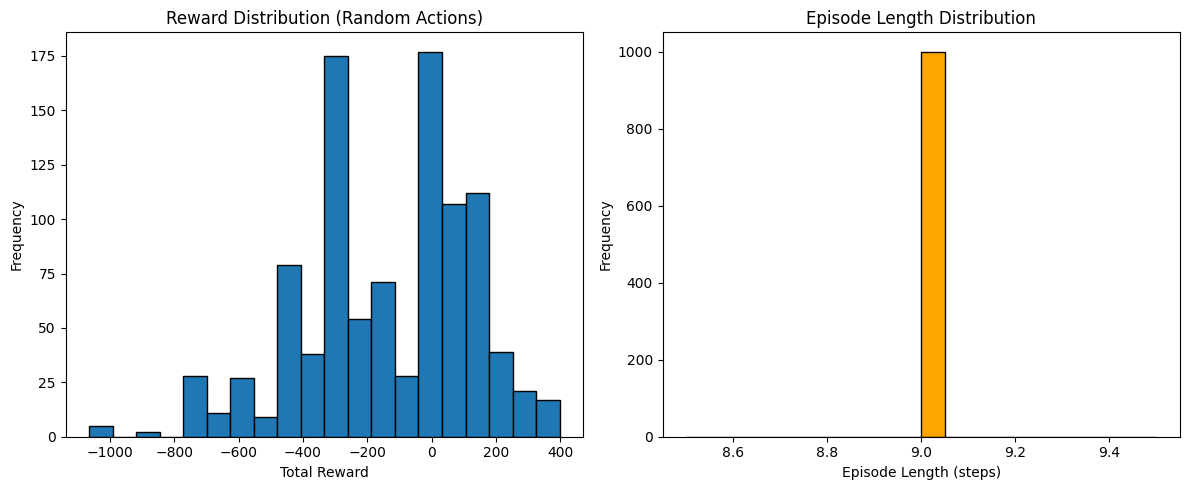


=== Example Episode Rewards ===
Episode 1: Reward = -317.33, Length = 9 steps
Episode 2: Reward = 181.33, Length = 9 steps
Episode 3: Reward = -146.67, Length = 9 steps
Episode 4: Reward = -301.33, Length = 9 steps
Episode 5: Reward = -584.00, Length = 9 steps


In [ ]:
# Reward Analysis

import matplotlib.pyplot as plt
import numpy as np

# Create the environment instance
env = TradingEnv(df)

# Analyze reward distribution
rewards = []
episode_lengths = []
max_steps = len(env.df) - 1

for _ in range(1000):
    obs, _ = env.reset()  # Reset returns (observation, info)
    terminated = False
    truncated = False
    total_reward = 0
    step = 0
    
    while not (terminated or truncated) and step < max_steps:
        action = env.action_space.sample()  # Random action
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        step += 1
    
    rewards.append(total_reward)
    episode_lengths.append(step)

# Calculate statistics
rewards = np.array(rewards)
episode_lengths = np.array(episode_lengths)

print("=== Reward Statistics ===")
print(f"Min: {np.min(rewards):.2f}")
print(f"Max: {np.max(rewards):.2f}")
print(f"Mean: {np.mean(rewards):.2f}")
print(f"Median: {np.median(rewards):.2f}")
print(f"Std: {np.std(rewards):.2f}")
print(f"Episodes with positive reward: {np.sum(rewards > 0)}/{len(rewards)}")
print(f"Average episode length: {np.mean(episode_lengths):.1f} steps")

# Plot reward distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(rewards, bins=20, edgecolor='black')
plt.title("Reward Distribution (Random Actions)")
plt.xlabel("Total Reward")
plt.ylabel("Frequency")

# Plot episode lengths
plt.subplot(1, 2, 2)
plt.hist(episode_lengths, bins=20, edgecolor='black', color='orange')
plt.title("Episode Length Distribution")
plt.xlabel("Episode Length (steps)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Print some example episodes
print("\n=== Example Episode Rewards ===")
for i in range(min(5, len(rewards))):
    print(f"Episode {i+1}: Reward = {rewards[i]:.2f}, Length = {episode_lengths[i]} steps")

In [58]:
# Output results from one model

buy_signals = []
sell_signals = []

print("Recording signals")

test_agent(PPO.load("sb3_ppo_model"), env, buy_signals, sell_signals)

Recording signals


TypeError: 'list' object cannot be interpreted as an integer

In [ ]:
# Ensure directories exist
import os
import joblib  # or import pickle
from itertools import product


os.makedirs("./tensorboard_logs/", exist_ok=True)
os.makedirs("./saved_models/", exist_ok=True)

def evaluate_model(model, env, num_episodes=10):
    total_rewards = []
    for _ in range(num_episodes):
        # Access the environment wrapped by DummyVecEnv and ActionMasker
        env_inner = env.get_attr("env", 0)[0]  # Get the first environment
        
        # Check if env_inner has an 'env' attribute (i.e., it's wrapped)
        if hasattr(env_inner, "env"):  
            env_inner = env_inner.env  # Unwrap ActionMasker if applicable

        obs, info = env_inner.reset()  # Reset the environment
        episode_reward = 0
        done = False

        while not done:
            for i in range(30):  # Run for a fixed number of steps
                # Extract the action mask from the original environment
                action_mask = env_inner.get_action_mask()  # Access get_action_mask from TradingEnv inside ActionMasker
    
                # Convert observation and mask to tensors
                obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=model.device).unsqueeze(0)
                action_mask_tensor = torch.as_tensor(action_mask, dtype=torch.float32, device=model.device).unsqueeze(0)
    
                # Predict action with action masking
                with torch.no_grad():
                    action, _, _ = model.policy.forward(obs_tensor, action_mask=action_mask_tensor, deterministic=True)
    
                action = action.cpu().numpy()[0]  # Convert action tensor to numpy
    
                # Step the environment
                obs, reward, done, truncated, info = env_inner.step(action)
    
                episode_reward += reward

                if done or truncated:  # If the episode ends, reset the environment
                    print(f"🎯 Total Reward: {episode_reward:.2f}")
                    obs = env_inner.reset()  # Reset environment, which only returns the observation
                    break  # Exit loop if episode ends

        total_rewards.append(episode_reward)

    return np.mean(total_rewards)

# Perform grid search
results = []
models = []

# Define hyperparameter ranges
ent_coef_range = [0.0]       # Lower values for stability
gamma_range = [0.99]              # Lower values for short-term focus
gae_lambda_range = [0.9]        # Wider range to test variance
n_steps_range = [4096]           # Larger values for more experiences
clip_range_range = [0.1]         # Narrower range for stability
n_epochs_range = [5]               # Fewer epochs for faster training
batch_size_range = [128]           # Larger batches for better performance

force = True

timesteps = 500000

for ent_coef, gamma, gae_lambda, n_steps, clip_range, n_epochs, batch_size in product(
    ent_coef_range, gamma_range, gae_lambda_range, n_steps_range, clip_range_range, n_epochs_range, batch_size_range
):
    model_filename = f"./saved_models/model_ent_coef={ent_coef}_gamma={gamma}_gae_lambda={gae_lambda}_n_steps={n_steps}_clip_range={clip_range}_n_epochs={n_epochs}_batch_size={batch_size}_timesteps={timesteps}.zip"
    
    if os.path.exists(model_filename) and not force:
        print(f"Model already exists: {model_filename}, loading instead of training...")
        model = PPO.load(model_filename, env=env)  # Load existing model
    else:
        print(f"Training new model with: ent_coef={ent_coef}, gamma={gamma}, gae_lambda={gae_lambda}, "
              f"n_steps={n_steps}, clip_range={clip_range}, n_epochs={n_epochs}, batch_size={batch_size}, timesteps={timesteps}")
    
        model = PPO(
            MaskedPPOPolicy,  # Replace with your policy (e.g., "MlpPolicy" or "CnnPolicy")
            env,
            ent_coef=ent_coef,
            gamma=gamma,
            gae_lambda=gae_lambda,
            n_steps=n_steps,
            clip_range=clip_range,
            n_epochs=n_epochs,
            batch_size=batch_size,
            verbose=0,  # Set to 0 for less output
            tensorboard_log="./tensorboard_logs/"
        )
        
        # Train for x timesteps
        model.learn(total_timesteps=timesteps)
    
        # Save the model
        model.save(model_filename)
        print(f"Model saved: {model_filename}")
    
        # Store the model and its parameters
        models.append({
            "model_filename": model_filename,  # Store the path to the saved model
            "params": {
                "ent_coef": ent_coef,
                "gamma": gamma,
                "gae_lambda": gae_lambda,
                "n_steps": n_steps,
                "clip_range": clip_range,
                "n_epochs": n_epochs,
                "batch_size": batch_size,
            }
        })

    # Evaluate the model
    total_reward = evaluate_model(model, env)
    print('Average total reward:', total_reward)

    env.close()  # Close all subprocesses
    
    results.append({
        "ent_coef": ent_coef,
        "gamma": gamma,
        "gae_lambda": gae_lambda,
        "n_steps": n_steps,
        "clip_range": clip_range,
        "n_epochs": n_epochs,
        "batch_size": batch_size,
        "total_reward": total_reward,
        "model_filename": model_filename  # Link results to the saved model
    })

# Save results to a CSV file
results_df = pd.DataFrame(results)
csv_filename = f"grid_search_results_{timesteps}_steps.csv"
results_df.to_csv(csv_filename, index=False)

base_csv, csv_ext = os.path.splitext(csv_filename)

# Append a counter if the file already exists
counter = 1
while os.path.exists(csv_filename):
    csv_filename = f"{base_csv}_{counter}{csv_ext}"
    counter += 1

# Save the results DataFrame to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

# Now, do the same for the models file
models_filename = "./saved_models/models_list.joblib"
base_model, model_ext = os.path.splitext(models_filename)

counter = 1
while os.path.exists(models_filename):
    models_filename = f"{base_model}_{counter}{model_ext}"
    counter += 1

# Save the models variable
joblib.dump(models, models_filename)
print(f"Models saved to {models_filename}")

print("Grid search completed. Results saved to", csv_filename)

In [ ]:
print('test')

In [ ]:
buy_signals

In [ ]:
sell_signals

In [ ]:
# Show learned buy and sell signals

import mplfinance as mpf
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame, buy_signals_1000, sell_signals_1000, buy_signals_10000, and sell_signals_10000 are your lists of timestamps

# Function to plot the signals for a given buy and sell signal list
def plot_signals(buy_signals, sell_signals, title):
    # Convert buy/sell signals to DatetimeIndex
    buy_signals = pd.to_datetime(buy_signals)  
    buy_signals = buy_signals[buy_signals.isin(df_original.index)]  # Filter buy signals to match df.index

    sell_signals = pd.to_datetime(sell_signals)  
    sell_signals = sell_signals[sell_signals.isin(df_original.index)]  # Filter sell signals to match df.index

    # Create new columns to mark the buy and sell signals with NaN for non-signals
    buy_signal_prices = df_original['close'].copy()
    buy_signal_prices[~df_original.index.isin(buy_signals)] = float('nan')  # Set non-buy signals to NaN
    
    sell_signal_prices = df_original['close'].copy()
    sell_signal_prices[~df_original.index.isin(sell_signals)] = float('nan')  # Set non-sell signals to NaN

    # Create addplots for buy and sell signals
    buy_signal_plot = mpf.make_addplot(buy_signal_prices, type='scatter', markersize=40, marker='^', color='green')
    sell_signal_plot = mpf.make_addplot(sell_signal_prices, type='scatter', markersize=40, marker='v', color='red')

    # Plot with the added buy and sell signals
    fig, axes = mpf.plot(
        df_original,
        type='ohlc',
        datetime_format='%Y-%m-%d %H:%M',
        addplot=[buy_signal_plot, sell_signal_plot],
        returnfig=True,
        figsize=(16, 8),
        warn_too_much_data=10000,
        title=title #Adjust the size again to maintain consistency
    )

plot_signals(buy_signals, sell_signals, title="Buy/Sell Signals")


In [ ]:
import mplfinance as mpf
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate profit based on buy and sell signals
def calculate_profit(buy_signals, sell_signals, df):
    buy_prices = df.loc[buy_signals, 'close']
    sell_prices = df.loc[sell_signals, 'close']

    # Ensure that the number of buy signals is less than or equal to the number of sell signals
    min_length = min(len(buy_prices), len(sell_prices))

    # Calculate profit for each pair of buy and sell signals
    profits = []
    for i in range(min_length):
        profit = sell_prices.iloc[i] - buy_prices.iloc[i]  # Profit = Sell Price - Buy Price
        profits.append(profit)

    total_profit = sum(profits)
    return total_profit, profits

# Function to plot the signals and compare profits
def plot_signals_and_compare_profit(buy_signals, sell_signals, df, title):
    # Convert buy/sell signals to DatetimeIndex
    buy_signals = pd.to_datetime(buy_signals)  
    buy_signals = buy_signals[buy_signals.isin(df.index)]  # Filter buy signals to match df.index

    sell_signals = pd.to_datetime(sell_signals)  
    sell_signals = sell_signals[sell_signals.isin(df.index)]  # Filter sell signals to match df.index

    # Create new columns to mark the buy and sell signals with NaN for non-signals
    buy_signal_prices = df['close'].copy()
    buy_signal_prices[~df.index.isin(buy_signals)] = float('nan')  # Set non-buy signals to NaN

    sell_signal_prices = df['close'].copy()
    sell_signal_prices[~df.index.isin(sell_signals)] = float('nan')  # Set non-sell signals to NaN

    # Create addplots for buy and sell signals
    buy_signal_plot = mpf.make_addplot(buy_signal_prices, type='scatter', markersize=40, marker='^', color='green')
    sell_signal_plot = mpf.make_addplot(sell_signal_prices, type='scatter', markersize=40, marker='v', color='red')

    # Plot with the added buy and sell signals
    fig, axes = mpf.plot(
        df,
        type='ohlc',
        style='charles',
        datetime_format='%Y-%m-%d %H:%M',
        addplot=[buy_signal_plot, sell_signal_plot],
        returnfig=True,
        figsize=(20, 10),
        warn_too_much_data=1000  # Adjust the size again to maintain consistency
    )

    # Customize x-axis
    #axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    #plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Add legend manually
    #plt.legend(['Buy Signals', 'Sell Signals'], loc='upper left')

    # Add title
    #plt.title(title)

    # Show the plot
    #plt.show()

    # Calculate and print profit for the signals
    total_profit, profits = calculate_profit(buy_signals, sell_signals, df)
    print(f"Total Profit for {title}: {total_profit:.2f}")
    return total_profit

# Calculate and plot for 1000 timesteps signals
profit_1000 = plot_signals_and_compare_profit(buy_signals_1000, sell_signals_1000, df, title="Profit for 1000 Timesteps")

# Calculate and plot for 10000 timesteps signals
profit_10000 = plot_signals_and_compare_profit(buy_signals_10000, sell_signals_10000, df, title="Profit for 10000 Timesteps")

# Calculate and plot for 100000 timesteps signals
#profit_100000 = plot_signals_and_compare_profit(buy_signals_100000, sell_signals_100000, df, title="Profit for 100000 Timesteps")


# Compare the total profits
print(f"Total Profit for 1000 Timesteps: {profit_1000:.2f}")
print(f"Total Profit for 10000 Timesteps: {profit_10000:.2f}")
#print(f"Total Profit for 100000 Timesteps: {profit_100000:.2f}")

In [ ]:
!pip install tensorboard

In [2]:
import sys
print(sys.version)
print(sys.executable)

3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]
/Users/larka/jupyter_env/bin/python3
